# A METHODOLOGY FOR CONDUCTING DESIGN TRADES RELATED TO ADVANCED IN-SPACE ASSEMBLY
This notebook presents a simplified version of the method developped in my thesis. The full document is available [here](https://smartech.gatech.edu/handle/1853/60818). 
## In-Space Assembly and Methodology Overview

* **CONTEXT:** Ambitious efforts are underway to return astronauts to deep space, but technical and health challenges will require new types of systems with more advanced capabilities. In-Space Assembly (ISA) can enable these new systems by freeing designs from the size limitations of launch vehicles.
* **BACKGROUND:** ISA can be performed along a spectrum of complexity. Simpler methods deliver large pieces that require few assembly tasks, but are bulky to fit in launch vehicles. Advanced methods deliver smaller pieces packaged efficiently, but require more assembly tasks. There is a tradeoff between number of deliveries and time of assembly.
![ISA](isa.png)
* **PROBLEM:** The choice of assembly strategy impacts the cost and duration of the entire mission.  The effects of these design choices must be modeled together in order to conduct design trades. Different ISA methods can be used on different parts of a design.
* **SOLUTION:** The method presented employs a network formulation to model both delivery and assembly logistics. In this network, the pieces of a structure must flow from their initial state to a final assembly state, via arcs representing deliveries and assembly tasks. The network flow is optimized to minimize both the amount of deliveries required and the time of total assembly.

## Creating the delivery-assembly network
### Input Settings

In [134]:
# the time range of the model
times = list(range(100))
# the number of pieces that must be delivered and assembled
number_of_pieces = 10
# the number of intermediate assembly states between delivery and completion
states = list(range(5))
# duration of assembly task required to progress to to next state
state_duration = [0,8,2,4,0]  
# states at which pieces can arrive from source, indicating complexity of ISA / efficiency of packaging
states_for_delivery = [1,2] 
# the frequency of the delivery methods
delivery_frequency= 15
# number of pieces able to be carried in a single delivery, [to state 1, to state 2] for each delivery method
delivery_capacities = [4,1]
# number of pieces that can be stored in each state
state_storage_capacity = [0,16,4,4,0]
# number of pieces that can be assembled simultaneously from that state
state_assembly_capacity = [0,1,1,number_of_pieces,number_of_pieces]
# state origins where precedence is enforced, meaning the previous piece must be completed before another can begin
states_for_precedence = [2,3]  


### Generating network nodes

In [135]:
nodes = [(s, t) for s in states for t in times if s > 0]
# add source
nodes.append((0, 0))
# add sink
nodes.append((max(states) + 1, max(times)))

#### Visualizing network nodes

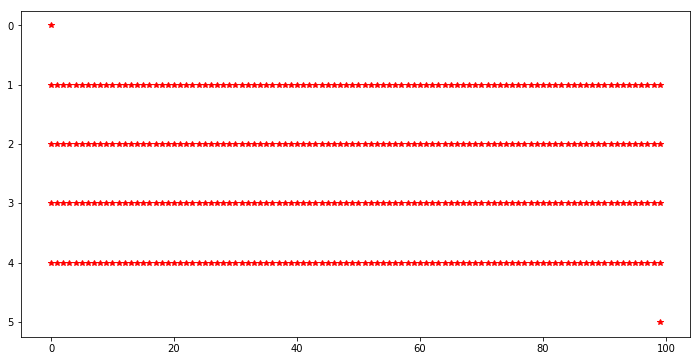

In [136]:
import matplotlib.pyplot as plt
%matplotlib inline
x_val = [x[0] for x in nodes]
y_val = [x[1] for x in nodes]
plt.figure(figsize=(12,6))
plt.gca().invert_yaxis()
plt.plot(y_val, x_val, 'r*')

### Generating arcs between nodes

In [137]:
# create arcs across same state to t+1
arcs = [(n, (n[0], n[1] + 1)) for n in nodes if (n[1] + 1 in times and state_storage_capacity[n[0]]!=0)]

# add arcs between states with duration specified
for i, dur in enumerate(state_duration):
    arcs.extend([(n, (n[0] + 1, n[1] + dur)) for n in nodes if(n[0] == i and n[0] + 1 in states and n[1] + dur in times)])

# add arcs to sink
for n in nodes:
    if n[0] == max(states):
        arcs.append((n, (max(states) + 1, max(times))))
        
arcs = set(arcs)
# add delivery arcs
for i in range(len(times)):
    if i % delivery_frequency == 0:
        for j in states_for_delivery:
            arcs.add(((0, 0), (j, i)))
            
arcs = list(arcs)


#### Visualizing arcs
Using curves to be able to differentiate the two types of deliveries.

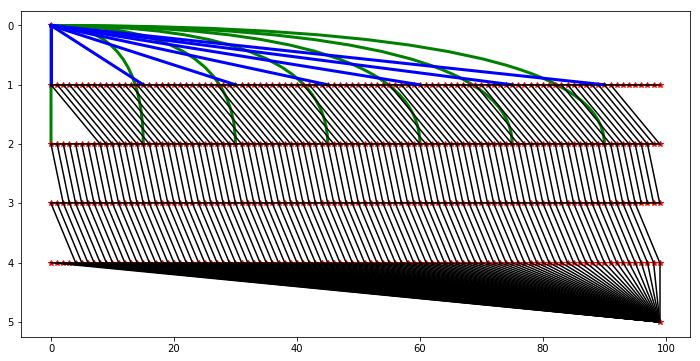

In [138]:
import matplotlib.path as mpath
import matplotlib.patches as mpatches

def draw_curved_delivery(ori, dest, alpha=1):
    Path = mpath.Path
    pp = mpatches.PathPatch(
        Path([(ori[1], ori[0]), (dest[1], ori[0]), (dest[1], dest[0])],
             [Path.MOVETO, Path.CURVE3, Path.CURVE3]),
        fc="none", transform=ax.transData, color='green', ls='-', alpha=alpha, linewidth=3)
    return pp

fig, ax = plt.subplots(figsize=(12,6))
plt.gca().invert_yaxis()
plt.plot(y_val, x_val, 'r*')

for ori,dest in arcs:
    if ori[0] == 0:
        if dest[0] == 1:
            plt.plot([ori[1], dest[1]], [ori[0], dest[0]], color='blue', linewidth=3)
        else:
            pp = draw_curved_delivery(ori, dest)
            ax.add_patch(pp)
    else:
        plt.plot([ori[1], dest[1]], [ori[0], dest[0]], 'k')

### Creating arc and node constraints

In [139]:
# arc constraints
arc_capacity = {}
for ori, dest in arcs:
    #  capacity of delivery arcs
    if ori[0]==0:
        for index, state in enumerate(states_for_delivery):
            if dest[0]== state:
                arc_capacity[(ori, dest)] = delivery_capacities[index]
                
    # capacity of storage arcs
    elif ori[0]==dest[0]:
        for index, state in enumerate(states):
            if ori[0]== state:
                arc_capacity[(ori, dest)] = state_storage_capacity[index]
                
    # capacity of assembly tasks
    else:
        for index, state in enumerate(states):
            if ori[0]== state:
                arc_capacity[(ori, dest)] = state_assembly_capacity[index]

# node constraints
node_inflow = {}
for n in nodes:
    node_inflow[n] = 0
node_inflow[(0, 0)] = number_of_pieces
node_inflow[(max(states) + 1, max(times))] = -number_of_pieces

## Building the optimization model

In [140]:
import pulp as plp
opt_model = plp.LpProblem(name="MIP Model")

arc_vars  = {(ori,dest):
plp.LpVariable(cat=plp.LpInteger, 
               lowBound=0, upBound=arc_capacity[(ori, dest)],
               name="arc_{0}_{1}".format(ori,dest)) 
for ori,dest in arcs}

# network flow constraint, what flows in must flow out
for n in nodes:
    opt_model += plp.lpSum(arc_vars[ori,dest] for ori,dest in [a for a in arcs if a[1]==n]) + node_inflow[n] == plp.lpSum(arc_vars[ori,dest] for ori,dest in [a for a in arcs if a[0]==n]), "node_conservation_{}".format(n)
    
# precedence constraint, pieces must be assembled sequentially
for t in times:
    arcs_to_relate = [a for a in arcs if
                      ((a[0][0] in states_for_precedence and not a[1][0]==min(states_for_precedence) and a[0][1] <= t and a[1][1] > t))]
    opt_model += plp.lpSum(arc_vars[ori,dest] for ori,dest in arcs_to_relate) <=1, "precedence_{}".format(t)
    
# delivery capacity constraint, the deliveries cannot exceed their capacity by combining two types of delivery states
for ori,dest in arcs:
    if ori[0]==0 and dest[0]==1:
        opt_model += plp.lpSum(arc_vars[ori,(state,dest[1])] * (1/delivery_capacities[index]) for index, state in enumerate(states_for_delivery)) <=1, "delivery_cap{}".format(dest[1])
                
# minimize total assembly time by weight to arcs proportional to time
objective = plp.lpSum(arc_vars[ori,dest]*dest[1] for ori,dest in arcs)
opt_model.sense = plp.LpMinimize
opt_model.setObjective(objective)

opt_model.writeLP("isa.lp")


In [141]:
for ori,dest in arcs:
    if ori[0]==0 and dest[0]==1:
        print(ori,dest)

(0, 0) (1, 15)
(0, 0) (1, 30)
(0, 0) (1, 0)
(0, 0) (1, 45)
(0, 0) (1, 60)
(0, 0) (1, 75)
(0, 0) (1, 90)


In [142]:
opt_model.solve()
print("Status:", plp.LpStatus[opt_model.status])

Status: Optimal


## Plot solution

storage happened (1, 17) (1, 18) 2.0
storage happened (1, 10) (1, 11) 1.0
storage happened (1, 9) (1, 10) 1.0
storage happened (1, 7) (1, 8) 1.0
storage happened (1, 6) (1, 7) 1.0
storage happened (1, 23) (1, 24) 1.0
storage happened (1, 19) (1, 20) 1.0
storage happened (1, 16) (1, 17) 2.0
storage happened (1, 22) (1, 23) 1.0
storage happened (1, 20) (1, 21) 1.0
storage happened (1, 15) (1, 16) 2.0
storage happened (1, 18) (1, 19) 1.0
storage happened (1, 5) (1, 6) 2.0
storage happened (1, 0) (1, 1) 2.0
storage happened (1, 3) (1, 4) 2.0
storage happened (1, 1) (1, 2) 2.0
storage happened (1, 11) (1, 12) 1.0
storage happened (1, 21) (1, 22) 1.0
storage happened (1, 4) (1, 5) 2.0
storage happened (1, 2) (1, 3) 2.0
storage happened (1, 8) (1, 9) 1.0


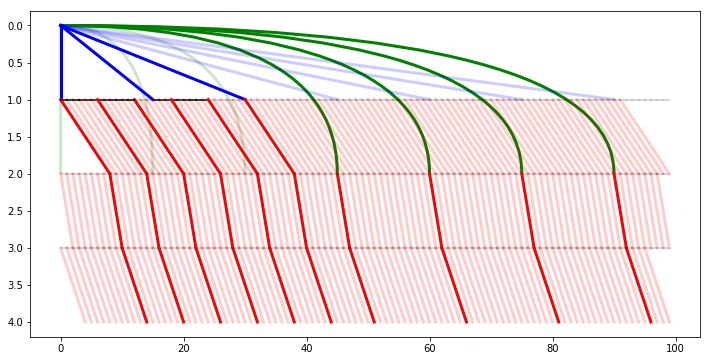

In [143]:
fig, ax = plt.subplots(figsize=(12,6))
# TRUSS PIECES
plt.gca().invert_yaxis()

for ori,dest in arcs:
    if plp.value(arc_vars[ori,dest]) > 0:
        alpha = 1
    else:
        alpha = 0.2
    if ori[0] == 0:
        if dest[0] == 1:
            plt.plot([ori[1], dest[1]], [ori[0], dest[0]], alpha = alpha, color='blue', linewidth=3)
        else:
            pp = draw_curved_delivery(ori, dest, alpha)
            ax.add_patch(pp)
    elif ori[0]!=dest[0] and dest[0]!=max(states)+1:
        plt.plot([ori[1], dest[1]], [ori[0], dest[0]], 'r', alpha = alpha, linewidth=3)
    elif dest[0]!=max(states)+1:
        plt.plot([ori[1], dest[1]], [ori[0], dest[0]], 'k', alpha = alpha)
        if plp.value(arc_vars[ori,dest]) > 0:
            print('storage happened', ori, dest, plp.value(arc_vars[ori,dest]))



In [144]:
# # GENERAL SETTINGS
# 
# arms = list(range(1))
# state_capacity_common = [0,1,1,1,99]
# # DELIVERY SETTINGS
# delivery_sizes_hab = list(range(2))
# delivery_frequencies = [5,30]
# delivery_capacities_truss = [[8,1],[16,2]] # [to state 1, to state 2] for each delivery method
# delivery_capacities_hab = [4,8] # [to state 1A, to state 1B] for each delivery method
# # TRUSS SETTINGS
# truss_pieces_per_arm = 8
#   # including source sink
# states_for_truss_delivery = [1,2]  # states at which pieces can arrive from source
# states_for_truss_precedence = [2,3]  # state origins where precedence is enforced
# states_for_truss_simul = [1,2,3]  # state origins where we care about simultaneity accross arms
# state_duration_truss = [0,3,5,2,0]  # duration to next state
# state_storage_truss = [0,16,4,4,0]
# state_capacity_truss = [0,1,1,1,99]
# # HAB SETTINGS
# angle_per_arm= 90
# states_for_hab = list(range(5)) # including source sink
# states_for_hab_precedence = [2,3] # states where precedence is enforced
# states_for_hab_simul = [2,3] # state origins where we care about simultaneity accross arms
# state_duration_hab = [0,0,3,1,0]
# state_storage_hab = [[0,0,4,4,0], [0,0,8,8,0]]
# state_capacity_hab = [[0,0,4,4,99], [0,0,8,8,99]] # second one used for cross-size
# state_capacity_hab_bin = [0,1,1,1,99]
# # COSTS SETTINGS
# delivery_costs = [1000,1500]  # first freq, second freq
# storage_costs_truss = [0,0.01,0.02,0.03,0]
# storage_costs_hab = [0,0.01,0.02,0.03,0]
# time_cost = 1


In [145]:
# # TRUSS
# # create nodes for truss

# # create arcs across same state to t+1
# arcs_for_truss = [(n, (n[0], n[1] + 1)) for n in nodes_for_truss if (n[1] + 1 in times and state_storage_truss[n[0]]!=0)]
# # add arcs between states with duration specified
# for i, dur in enumerate(state_duration_truss):
#     arcs_for_truss.extend([(n, (n[0] + 1, n[1] + dur)) for n in nodes_for_truss if(n[0] == i and n[0] + 1 in states_for_truss and n[1] + dur in times)])
# # add arcs to sink
# for n in nodes_for_truss:
#     if n[0] == max(states_for_truss):
#         arcs_for_truss.append((n, (max(states_for_truss) + 1, max(times))))
# # insert source node
# nodes_for_truss.insert(0, (0, 0))
# # add delivery arcs



In [146]:
# # GENERAL SETTINGS
# times = list(range(80))
# arms = list(range(1))
# state_capacity_common = [0,1,1,1,99]
# # DELIVERY SETTINGS
# delivery_sizes_hab = list(range(2))
# delivery_frequencies = [5,30]
# delivery_capacities_truss = [[8,1],[16,2]] # [to state 1, to state 2] for each delivery method
# delivery_capacities_hab = [4,8] # [to state 1A, to state 1B] for each delivery method
# # TRUSS SETTINGS
# truss_pieces_per_arm = 8
# states_for_truss = list(range(5))  # including source sink
# states_for_truss_delivery = [1,2]  # states at which pieces can arrive from source
# states_for_truss_precedence = [2,3]  # state origins where precedence is enforced
# states_for_truss_simul = [1,2,3]  # state origins where we care about simultaneity accross arms
# state_duration_truss = [0,3,5,2,0]  # duration to next state
# state_storage_truss = [0,16,4,4,0]
# state_capacity_truss = [0,1,1,1,99]
# # HAB SETTINGS
# angle_per_arm= 90
# states_for_hab = list(range(5)) # including source sink
# states_for_hab_precedence = [2,3] # states where precedence is enforced
# states_for_hab_simul = [2,3] # state origins where we care about simultaneity accross arms
# state_duration_hab = [0,0,3,1,0]
# state_storage_hab = [[0,0,4,4,0], [0,0,8,8,0]]
# state_capacity_hab = [[0,0,4,4,99], [0,0,8,8,99]] # second one used for cross-size
# state_capacity_hab_bin = [0,1,1,1,99]
# # COSTS SETTINGS
# delivery_costs = [1000,1500]  # first freq, second freq
# storage_costs_truss = [0,0.01,0.02,0.03,0]
# storage_costs_hab = [0,0.01,0.02,0.03,0]
# time_cost = 1
